# Time Series Feature Extraction

## Import Package

In [1]:
import numpy as np
import pandas as pd
import pickle
from scipy import stats
from scipy.stats import linregress
from sklearn.model_selection import GridSearchCV,GroupKFold
from sklearn.metrics import confusion_matrix, classification_report
from xgboost import XGBClassifier 
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
import shap 

## Feature Extraction 

#### Data loaded in between as pandas dataframe ndf_w from secure source

### Functions for Customized Feature Extration

In [22]:
# function defined to calculated rolling max, min, difference and rolling cummulative max difference 
def featurecalc_rolling_cor_maxmin(ndf_w, endog_vars,win):
    for var in endog_vars:
        x = ndf_w.groupby('wellmotor_denserank')[var].rolling(win,min_periods=1,center=False).max().values
        y = ndf_w.groupby('wellmotor_denserank')[var].rolling(win,min_periods=1,center=False).min().values
        
        ndf_w[var + 'rolling_mm'+ str(win)] =  x-y
        ndf_w[var + 'rolling_mm'+ str(win)+'_cummax'] = ndf_w.groupby('wellmotor_denserank')[var + 'rolling_mm'+ str(win)].cummax()
       
        del x
        del y
    output = ndf_w
    return output

In [27]:
def get_slope(array):
    y = np.array(array)
    x = np.arange(len(y))
    slope, intercept, r_value, p_value, std_err = linregress(x,y)
    return slope

In [28]:
def featurecalc_work_delta(ndf_w, win,endog_vars):
      
    for var in endog_vars:
        ndf_w[var+'_slope_'+str(win)] = ndf_w.groupby('wellmotor_denserank')[var].rolling(window=win,min_periods=1).apply(get_slope, raw=False).reset_index(0, drop=True)
      
    return ndf_w

### Calculate Feature with Given Variables and Parameters

In [29]:
endog_vars = ['max_power_60sec']
win = 20
ndf_w = featurecalc_rolling_cor_maxmin(ndf_w, endog_vars,win)

ndf_w['WMOpMin'] = ndf_w['wellmotor_denserank'].map(str) + ndf_w['opsec60'].map(str)

win = 10
endog_vars = ['max_diff_60sec', 'max_woba_60sec', 'max_torq_60sec','min_ROPT_60sec']
ndf_w = featurecalc_work_delta(ndf_w,win,endog_vars)

In [31]:
ndf_w = ndf_w.loc[:,~ndf_w.columns.duplicated()]

In [32]:
#################################### Model 

## Prepare for Model

In [33]:
input_cols = [
       'depthdrilled', 'timedrilled',
       'power_cum', 'PickUpLessthan10second_cum', 'ReamingTimeSec_cum',
       'OffBottomTimeSec_cum', 'ConnectionDiff600Sec_cum',
       'DrillOffTimesec_cum', 'diff_spike_10sec_count_cum',
       'diff_spike_10sec_cum', 'torq_spike_5sec_count_cum',
       'torq_spike_5sec_cum', 'diff_spike_5sec_count_cum',
       'diff_spike_5sec_cum', 'low_rop_flag',
       'ropt_cummax', 'ropt_drop_flag_count','max_power_60secrolling_mm20_cummax',
       'diff_60sec_maxmin_minflag_cum2', 'diff_60sec_4minwarning_cum2',
       'woba_60sec_maxmin_minflag_cum2', 'woba_60sec_4minwarning_cum2',
        'torq_60sec_maxmin_minflag_cum2',
       'torq_60sec_4minwarning_cum2', 
       'max_diff_60sec_slope_10', 'max_woba_60sec_slope_10',
       'max_torq_60sec_slope_10', 'min_ROPT_60sec_slope_10']

In [35]:
ndf_w['depth_til_end'] = ndf_w.groupby(['wellmotor_denserank'])['max_DMEA_60sec'].transform('max') - ndf_w['max_DMEA_60sec']
ndf_w['Fail_next_1000ft'] = 0
ndf_w.loc[(ndf_w.depth_til_end < 1000) & (ndf_w.motorresult == 'a_Motor_Failure'), 'Fail_next_1000ft'] = 1
ndf_w.loc[(ndf_w.depth_til_end < 500) & (ndf_w.motorresult == 'a_Motor_Failure'), 'Fail_next_500ft'] = 1

### Separate Training and Validation Set

In [36]:
ndf_w['TestDataSet'] =  0 
ndf_w.loc[(pd.to_datetime(ndf_w['opsec60']) - pd.to_datetime('today') > '-120 days +00:00:00'), 'TestDataSet'] = 1

In [37]:
output_col = 'Fail_next_1000ft'  
X = ndf_w[ndf_w.TestDataSet == 0][input_cols]
Y = ndf_w[ndf_w.TestDataSet == 0][output_col]

In [38]:
## Data Set Ready for Model Preparation 

### Separate Training and Testing Set

In [39]:
print('original data: ',len(Y))
print('original flag: ',sum(Y))
X = X.loc[:,~X.columns.duplicated()]
X = X.replace([np.inf, -np.inf], np.nan)
Y = Y.replace([np.inf, -np.inf], np.nan)
X = X.astype(np.float32)
#X = X.mask(np.isinf(X)).fillna(0)
X = X.fillna(0)
Y = Y.astype(np.float32)
Y = Y.fillna(0)

train_len = int(len(X) * 0.7)
X_train = X.iloc[:train_len]
X_test = X.iloc[train_len:]
y_train = Y.iloc[:train_len]
y_test = Y.iloc[train_len:]

sampling_strategy=0.5
ros = RandomOverSampler(sampling_strategy)

x_train_ros, y_train_ros = ros.fit_sample(X_train, y_train)
X_train_s = pd.DataFrame(x_train_ros, columns = input_cols)

print('original data X_train:',len(X_train))
print('sample flag X_train:',len(X_train_s))
print('sample flag y_train:',sum(y_train_ros))

original data: 233156
original flag: 44669
original data X_train: 163209
sample flag X_train: 200160
sample flag y_train: 66720.0

In [40]:
def my_scorer(clf, X, Y):
#     class_labels = clf.classes_
    y_pred_proba = clf.predict_proba(X)[:, 1]
    
    value = 0
    y_true = Y[:,].tolist()
    for index in range(len(y_pred_proba)):
        # print(index)
        if y_true[index] == 0 and y_pred_proba[index] == 0:
            value -= 0 
        elif y_true[index] == 0 and y_pred_proba[index] == 1:
            value += -1.5  #### false prediction has dmg
        elif y_true[index] == 1 and y_pred_proba[index] == 0:
            value += 0  #### no cost 
        elif y_true[index] == 1 and y_pred_proba[index] == 1:
            value += 0.4  #### value 
        else:
            value += 0
    return value

## Modeling

### Grid Search and Hyperparameter Tuning

In [41]:
def grid_search_xgboost(useful_columns,n_splits=5):
    param_grid = {"learning_rate"    : [0.2] ,
         "max_depth"        : [6,7,8,9],
         "min_child_weight" : [1,2,3],
         "gamma"            : [0.2,0.5],
         "random_state" : [0,42]  }

    X = X_train_s
    Y = y_train_ros
    groups = X.index.get_level_values(0)
    model = XGBClassifier(n_estimators=100)
    clf = GridSearchCV(model
                       , param_grid
#                        , scoring=my_scorer
                       , scoring="f1"
                       , verbose = 1
                       , n_jobs = 2
                       , cv=GroupKFold(n_splits=5).get_n_splits(X, Y, groups))
    clf.fit(X, Y)
    return clf
  
clat = grid_search_xgboost(input_cols)

print(clat.best_estimator_)

In [42]:
xgb = clat.best_estimator_

In [43]:
model = xgb.fit(X_train_s[input_cols], y_train_ros, verbose = True)

In [45]:
pickle.dump(model, (open('/dbfs/FileStore/MMF/MMF_M30_D08_V4_retrain_Model_v2_1000.p', "wb")))  

In [46]:
model = pickle.load(open('/dbfs/FileStore/MMF/MMF_M30_D08_V4_retrain_Model.p', "rb"))

In [47]:
ndf_w['max_depthdrilled'] = ndf_w.groupby(['wellmotor_denserank'])['depthdrilled'].transform('max')
newdata = ndf_w[(ndf_w.TestDataSet == 1) & (ndf_w.max_depthdrilled > 2000)][input_cols].reset_index(drop = False)
pred_proba = model.predict_proba(newdata[input_cols])[:, 1]
result = ndf_w[(ndf_w.TestDataSet == 1) & (ndf_w.max_depthdrilled > 2000)]
result['Pred_prob'] = pred_proba
result.loc[(result.Pred_prob >= 1), 'Pred_prob'] = 1  
result['Pred_prob_avg'] =  result.groupby('wellmotor_denserank')['Pred_prob'].rolling(15,center=False).mean().values

### Model Evaluation

In [50]:
## feature importance extracted for later use
fi = pd.DataFrame()
fi['imp'] = model.feature_importances_
fi['feature name'] = X_test.columns.tolist()
with pd.option_context('display.max_rows', None, 'display.max_columns', None):print(fi.sort_values(by=['imp'],ascending=False))

imp feature name
13 0.094654 diff_spike_5sec_cum
4 0.087704 ReamingTimeSec_cum
18 0.083734 diff_60sec_maxmin_minflag_cum2
9 0.082633 diff_spike_10sec_cum
17 0.065250 max_power_60secrolling_mm20_cummax
23 0.054805 torq_60sec_4minwarning_cum2
22 0.049912 torq_60sec_maxmin_minflag_cum2
19 0.045360 diff_60sec_4minwarning_cum2
20 0.043801 woba_60sec_maxmin_minflag_cum2
2 0.039894 power_cum
21 0.036447 woba_60sec_4minwarning_cum2
12 0.036311 diff_spike_5sec_count_cum
6 0.035448 ConnectionDiff600Sec_cum
11 0.035368 torq_spike_5sec_cum
10 0.033445 torq_spike_5sec_count_cum
7 0.031400 DrillOffTimesec_cum
8 0.030996 diff_spike_10sec_count_cum
0 0.028804 depthdrilled
5 0.028392 OffBottomTimeSec_cum
1 0.024362 timedrilled
16 0.023464 ropt_drop_flag_count
15 0.004493 ropt_cummax
27 0.001121 min_ROPT_60sec_slope_10
26 0.001018 max_torq_60sec_slope_10
25 0.000653 max_woba_60sec_slope_10
24 0.000530 max_diff_60sec_slope_10
3 0.000000 PickUpLessthan10second_cum
14 0.000000 low_rop_flag

In [53]:
## Model Evaluation for f1 score
pd.DataFrame(classification_report(result.Fail_next_1000ft, result.Pred_Threshold,output_dict=True)).transpose()

,f1-score,precision,recall,support
0,0.944090,0.903981,0.987923,74770.000000
1,0.170789,0.499446,0.103007,8747.000000
accuracy,0.895243,0.895243,0.895243,0.895243
macro avg,0.557440,0.701713,0.545465,83517.000000
weighted avg,0.863100,0.861613,0.895243,83517.000000


In [54]:
## threshold sweep based on least damaging true positive and false positive cost
BestThreshold = 0
BestValue = 0 
BestTP = 0
BestFP = 0
TotalPrediction = 0
tp_value=0.15
fp_cost=-1.5
for i in range (50,97,1):
    print(i)
    result['Pred_Threshold'] = 0
    Threshold = i/100
    Precision = 0
    result.loc[(result.Pred_prob_avg >= Threshold), 'Pred_Threshold'] = 1  
    
    pd.DataFrame(classification_report(result.Fail_next_1000ft, result.Pred_Threshold,output_dict=True)).transpose()
    tn,FP,fn,TP = confusion_matrix(result.Fail_next_1000ft, result.Pred_Threshold).ravel()
    value = tp_value*TP+fp_cost*FP
    print('Precision:',Precision,'TP:',TP, 'FP:',FP,'Threshold',Threshold,'value:',value/1000000)
    
    if value >= BestValue:
        BestThreshold = Threshold
        BestValue = value
        BestTP = TP
        BestFP = FP
      

    print('Best:',BestThreshold,BestTP,BestFP,TotalPrediction)

50

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
Precision: 0 TP: 1870 FP: 4804 Threshold 0.5 value: -0.0069255
51
Precision: 0 TP: 1846 FP: 4693 Threshold 0.51 value: -0.0067626000000000006
52
Precision: 0 TP: 1813 FP: 4619 Threshold 0.52 value: -0.00665655
53
Precision: 0 TP: 1797 FP: 4563 Threshold 0.53 value: -0.0065749499999999995
54
Precision: 0 TP: 1787 FP: 4494 Threshold 0.54 value: -0.00647295
55
Precision: 0 TP: 1784 FP: 4402 Threshold 0.55 value: -0.0063354
56
Precision: 0 TP: 1775 FP: 4335 Threshold 0.56 value: -0.00623625
57
Precision: 0 TP: 1764 FP: 4229 Threshold 0.57 value: -0.0060789
58
Precision: 0 TP: 1640 FP: 4159 Threshold 0.58 value: -0.0059925
59
Precision: 0 TP: 1559 FP: 4083 Threshold 0.59 value: -0.00589065
60
Precision: 0 TP: 1544 FP: 3956 Threshold 0.6 value: -0.0057024
61
Precision: 0 TP: 1536 FP: 3826 Threshold 0.61 value: -0.005508600000000001
62
Precision: 0 TP: 1522 FP: 3653 Threshold 0.62 value: -0.0052512
63
Precision: 0 TP: 1517 FP: 3562 Threshold 0.63 value: -0.00511545
64
Precision: 0 TP: 1513 FP: 3419 Threshold 0.64 value: -0.00490155
65
Precision: 0 TP: 1509 FP: 3316 Threshold 0.65 value: -0.00474765
66
Precision: 0 TP: 1493 FP: 3218 Threshold 0.66 value: -0.00460305
67
Precision: 0 TP: 1459 FP: 3131 Threshold 0.67 value: -0.00447765
68
Precision: 0 TP: 1451 FP: 3050 Threshold 0.68 value: -0.00435735
69
Precision: 0 TP: 1400 FP: 2931 Threshold 0.69 value: -0.0041865
70
Precision: 0 TP: 1387 FP: 2863 Threshold 0.7 value: -0.00408645
71
Precision: 0 TP: 1383 FP: 2819 Threshold 0.71 value: -0.00402105
72
Precision: 0 TP: 1381 FP: 2750 Threshold 0.72 value: -0.00391785
73
Precision: 0 TP: 1379 FP: 2721 Threshold 0.73 value: -0.00387465
74
Precision: 0 TP: 1351 FP: 2698 Threshold 0.74 value: -0.00384435
75
Precision: 0 TP: 1297 FP: 2677 Threshold 0.75 value: -0.0038209499999999996
76
Precision: 0 TP: 1252 FP: 2624 Threshold 0.76 value: -0.0037481999999999997
77
Precision: 0 TP: 1241 FP: 2587 Threshold 0.77 value: -0.00369435
78
Precision: 0 TP: 1241 FP: 2560 Threshold 0.78 value: -0.0036538499999999997
79
Precision: 0 TP: 1241 FP: 2549 Threshold 0.79 value: -0.0036373499999999997
80
Precision: 0 TP: 1241 FP: 2486 Threshold 0.8 value: -0.0035428499999999997
81
Precision: 0 TP: 1241 FP: 2421 Threshold 0.81 value: -0.00344535
82
Precision: 0 TP: 1241 FP: 2393 Threshold 0.82 value: -0.00340335
83
Precision: 0 TP: 1241 FP: 2353 Threshold 0.83 value: -0.0033433499999999997
84
Precision: 0 TP: 1241 FP: 2295 Threshold 0.84 value: -0.00325635
85
Precision: 0 TP: 1230 FP: 2272 Threshold 0.85 value: -0.0032235
86
Precision: 0 TP: 1219 FP: 2225 Threshold 0.86 value: -0.00315465
87
Precision: 0 TP: 1206 FP: 2084 Threshold 0.87 value: -0.0029451
88
Precision: 0 TP: 1188 FP: 2004 Threshold 0.88 value: -0.0028278
89
Precision: 0 TP: 1129 FP: 1938 Threshold 0.89 value: -0.00273765
90
Precision: 0 TP: 1046 FP: 1868 Threshold 0.9 value: -0.0026451
91
Precision: 0 TP: 987 FP: 1796 Threshold 0.91 value: -0.00254595
92
Precision: 0 TP: 986 FP: 1672 Threshold 0.92 value: -0.0023601
93
Precision: 0 TP: 984 FP: 1524 Threshold 0.93 value: -0.0021384
94
Precision: 0 TP: 982 FP: 1232 Threshold 0.94 value: -0.0017007
95
Precision: 0 TP: 964 FP: 1123 Threshold 0.95 value: -0.0015399
96
Precision: 0 TP: 901 FP: 903 Threshold 0.96 value: -0.00121935
Best: 0 0 0 0

## Model Interpretation 

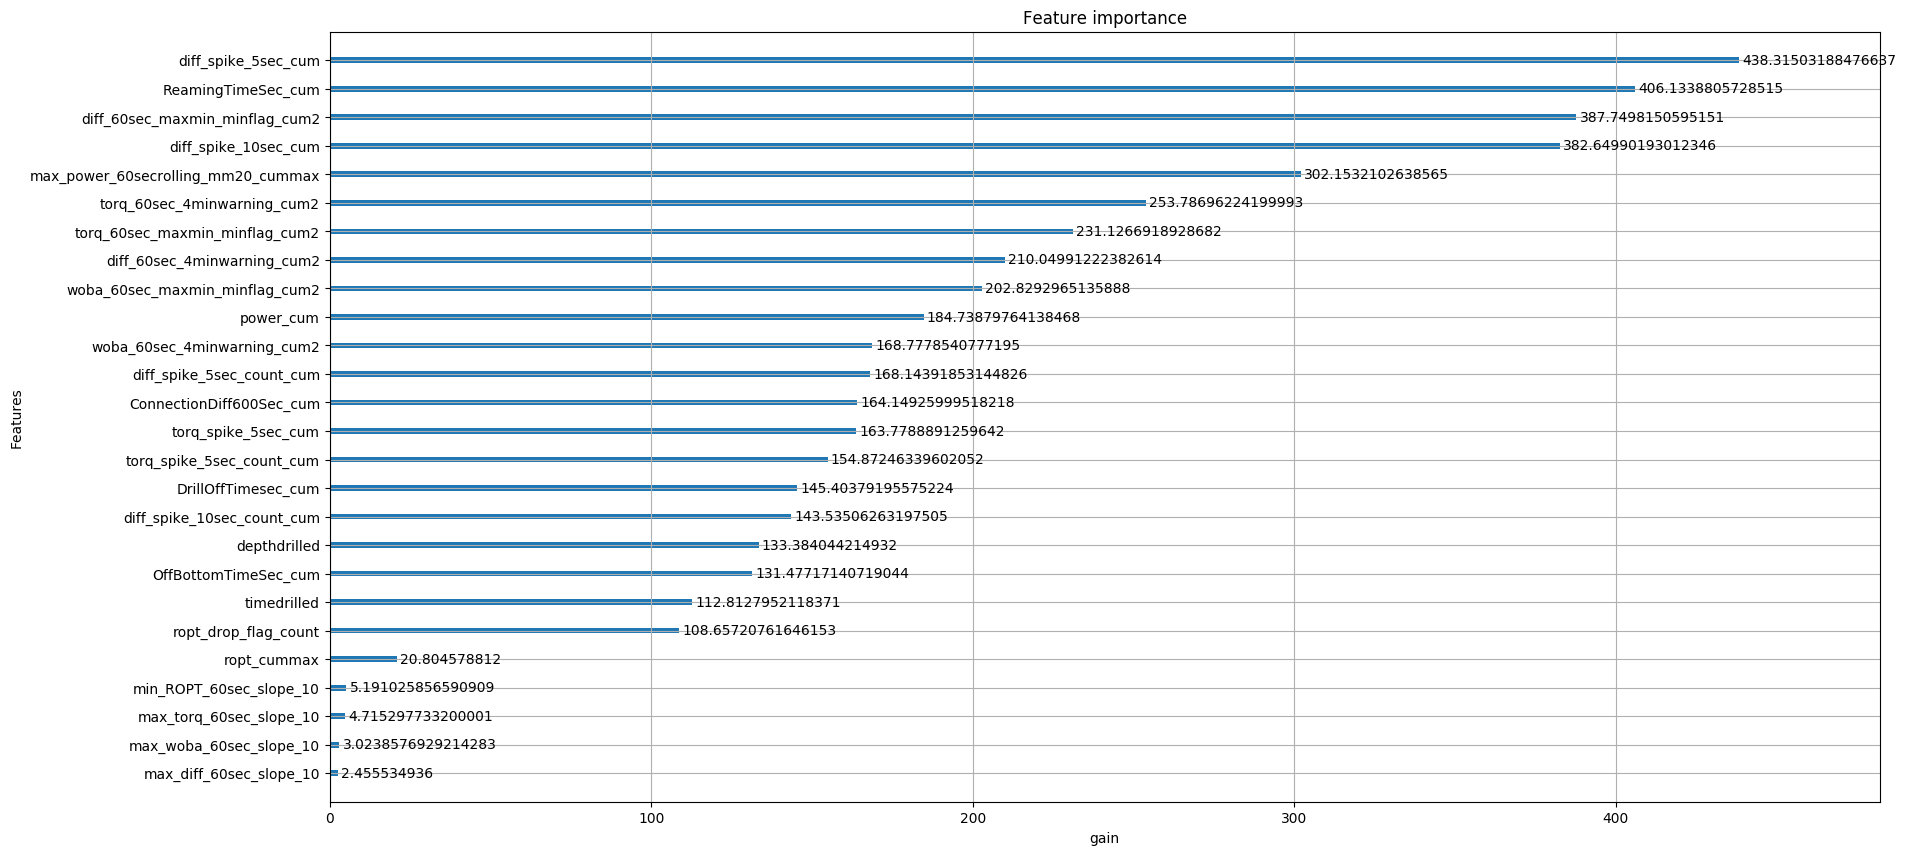

In [55]:
# Feature Importance for gain
fig, ax = plt.subplots(1,1,figsize=(20,10))
gain = xgboost.plot_importance(model, xlabel='gain', importance_type='gain',ax = ax)
display(gain.figure)

In [56]:
## Utilizing shap for further model interpretation
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(newdata[input_cols])

shap_values_df = pd.DataFrame(shap_values, columns = newdata[input_cols].columns +'_SHAP', index=newdata[input_cols].index)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
NPY_ARRAY_UPDATEIFCOPY, NPY_ARRAY_INOUT_ARRAY, and NPY_ARRAY_INOUT_FARRAY are deprecated, use NPY_WRITEBACKIFCOPY, NPY_ARRAY_INOUT_ARRAY2, or NPY_ARRAY_INOUT_FARRAY2 respectively instead, and call PyArray_ResolveWritebackIfCopy before the array is deallocated, i.e. before the last call to Py_DECREF.
UPDATEIFCOPY detected in array_dealloc. Required call to PyArray_ResolveWritebackIfCopy or PyArray_DiscardWritebackIfCopy is missing

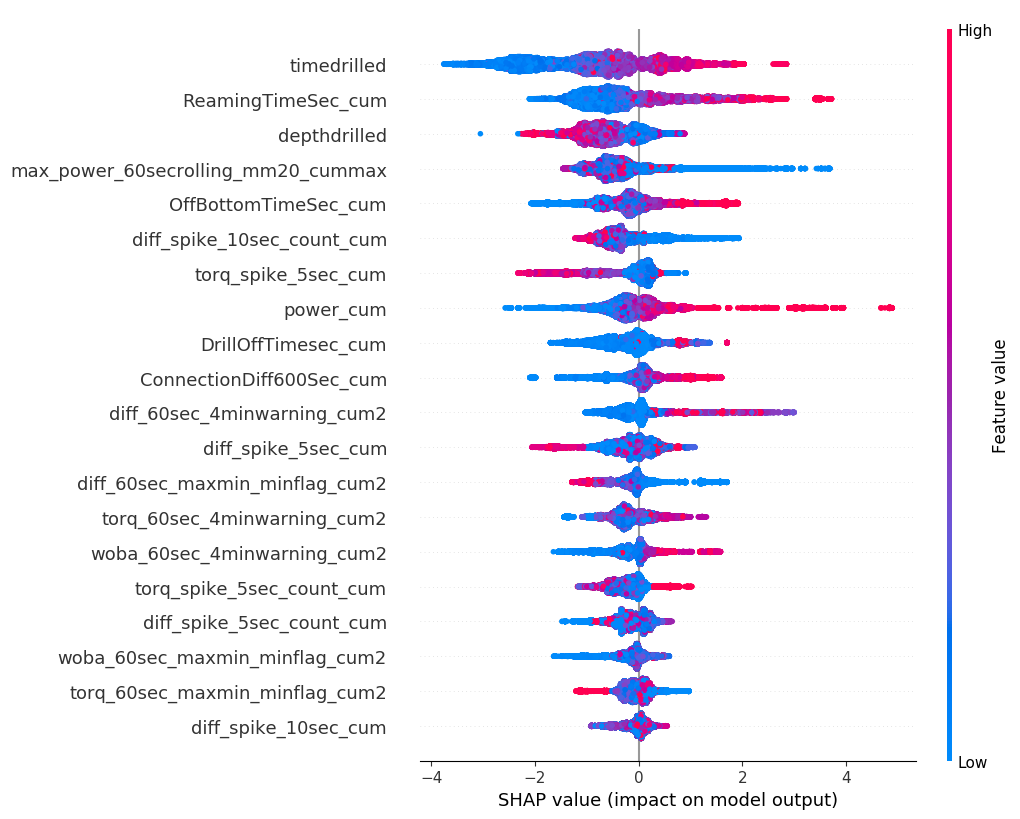

In [57]:
#overal feature value impact
fig2 = shap.summary_plot(shap_values, newdata[input_cols])
display(fig2)

In [58]:
newdata['Pred_prob'] = result['Pred_prob'].values

newdata['Pred_prob_avg'] =  result['Pred_prob_avg'].values
newdata['Fail_next_1000ft'] =  result['Fail_next_1000ft'].values
newdata.loc[(newdata.Pred_prob_avg >= 1), 'Pred_prob_avg'] = 1  

In [59]:
newdata.columns

Out[81]: Index(['wellmotor', 'opsec60', 'depthdrilled', 'timedrilled', 'power_cum',
 'PickUpLessthan10second_cum', 'ReamingTimeSec_cum',
 'OffBottomTimeSec_cum', 'ConnectionDiff600Sec_cum',
 'DrillOffTimesec_cum', 'diff_spike_10sec_count_cum',
 'diff_spike_10sec_cum', 'torq_spike_5sec_count_cum',
 'torq_spike_5sec_cum', 'diff_spike_5sec_count_cum',
 'diff_spike_5sec_cum', 'low_rop_flag', 'ropt_cummax',
 'ropt_drop_flag_count', 'max_power_60secrolling_mm20_cummax',
 'diff_60sec_maxmin_minflag_cum2', 'diff_60sec_4minwarning_cum2',
 'woba_60sec_maxmin_minflag_cum2', 'woba_60sec_4minwarning_cum2',
 'torq_60sec_maxmin_minflag_cum2', 'torq_60sec_4minwarning_cum2',
 'max_diff_60sec_slope_10', 'max_woba_60sec_slope_10',
 'max_torq_60sec_slope_10', 'min_ROPT_60sec_slope_10', 'Pred_prob',
 'Pred_prob_avg', 'Fail_next_1000ft'],
 dtype='object')

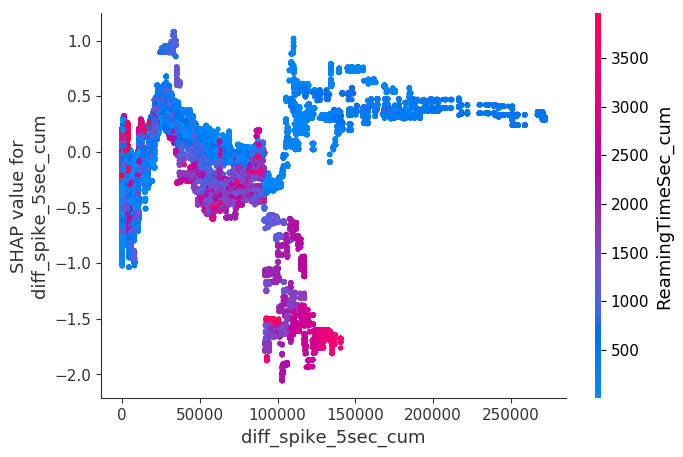

In [60]:
# specificed dependence plot between diff_spike_5sec_cun abd ReanubgtimeSec_cum
fig3 = shap.dependence_plot("diff_spike_5sec_cum",shap_values, newdata[input_cols])
display(fig3)

In [61]:
X_shap_values_df = pd.concat([newdata, shap_values_df], axis=1)
X_shap_values_df.to_csv('/dbfs/FileStore/MMF/MMF_M30_D08_V4_retrain_Model_shapvalue.csv')
#https://eastus.azuredatabricks.net/files/MMF/MMF_M30_D08_V1_retrain_Model_shapvalue.csv?o=5852914501436505